In [2]:
import pandas as pd
import numpy as np
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt

from scipy import interp

import warnings
import seaborn as sns
sns.despine()

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import binarize

from sklearn.pipeline import Pipeline
try:
    from sklearn.externals import joblib
except ImportError:
    import joblib

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

import sys
sys.path.append('../scripts')
from helper_functions import *

<Figure size 432x288 with 0 Axes>

### Load Funsite-PPI training and validation datasets

In [3]:
training_data_ML = pd.read_csv('../datasets/PPI/PPI_training_dataset.csv')
validation_data_ML = pd.read_csv('../datasets/PPI/PPI_validation_dataset.csv')

### Add the geometricus features to the data

In [5]:
geometricus_training_kmers = pd.read_csv('../datasets/PPI/geometricus_training_kmers.csv')
geometricus_training_radii = pd.read_csv('../datasets/PPI/geometricus_training_radii.csv')
geometricus_validation_kmers = pd.read_csv('../datasets/PPI/geometricus_validation_kmers.csv')
geometricus_validation_radii = pd.read_csv('../datasets/PPI/geometricus_validation_radii.csv')

training_data_ML = training_data_ML.join(geometricus_training_kmers)
training_data_ML = training_data_ML.join(geometricus_training_radii)

validation_data_ML = validation_data_ML.join(geometricus_validation_kmers)
validation_data_ML = validation_data_ML.join(geometricus_validation_radii)

#### Define Features to use in the PPI model

In [35]:
features_ff = ['scons','avg_scons','sc5_gs','sc5_scons', 'conserved_hotspot_struc_neighbourhood', 'conserved_surface_hotspot_struc_neighbourhood', 'highly_conserved_struc_neighbourhood', 'highly_conserved_surface_struc_neighbourhood', 'pocket_conserved_struc_neighbourhood', 'pocket_surface_conserved_struc_neighbourhood',
               'avg_charged', 'avg_cx', 'avg_dpx', 'avg_electric_effect', 'avg_flexibility', 'avg_hydropathicity', 'avg_hydrophobicity', 'avg_polarity', 'avg_surface_residues', 'avg_surrounding_hydrophobicity', 'dist_to_hotspot', 'dist_to_surface', 'hotspot_struc_neighbourhood', 'pocket_struc_neighbourhood', 'surface_residues_struc_neighbourhood', 'min_dist_to_cleft123', 'min_dist_to_cleft_1', 'min_dist_to_cleft_2', 'min_dist_to_cleft_3', 'surface_residue_rsa', 'cleft_residue', 'hydrophobic_aa', 'polar_aa',
               'alpha','betweenness','bulkiness','charge','cleft_depth','cleft_num','closeness','degree','foldx_alascan','free_energy_solution','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','hydrophobicity_psaia','kappa','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','nhBonds_ptr','oBonds_ptr','phi','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','rsa_mainchain','rsa_nonpolar','rsa_polar','rsa_totside','van_der_waals_vol_normalised',
               'dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'A_pssm_ff','A_wop_ff','C_pssm_ff','C_wop_ff','D_pssm_ff','D_wop_ff','E_pssm_ff','E_wop_ff','F_pssm_ff','F_wop_ff','G_pssm_ff','G_wop_ff','H_pssm_ff','H_wop_ff','I_pssm_ff','I_wop_ff','K_pssm_ff','K_wop_ff','L_pssm_ff','L_wop_ff','M_pssm_ff','M_wop_ff','N_pssm_ff','N_wop_ff','P_pssm_ff','P_wop_ff','Q_pssm_ff','Q_wop_ff','R_pssm_ff','R_wop_ff','S_pssm_ff','S_wop_ff','T_pssm_ff','T_wop_ff','V_pssm_ff','V_wop_ff','W_pssm_ff','W_wop_ff','Y_pssm_ff','Y_wop_ff','gapless_match_to_pseudocounts_ff','info_per_pos_ff',
              ]

features_generic = [
               'bulkiness','charge','cleft_depth','cleft_num','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','mutability','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','van_der_waals_vol_normalised','dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'residue_aa_A','residue_aa_C','residue_aa_D','residue_aa_E','residue_aa_F','residue_aa_G','residue_aa_H','residue_aa_I','residue_aa_K','residue_aa_L','residue_aa_M','residue_aa_N','residue_aa_P','residue_aa_Q','residue_aa_R','residue_aa_S','residue_aa_T','residue_aa_V','residue_aa_W','residue_aa_Y',
               'A_pssm_psiblast','A_wop_psiblast','C_pssm_psiblast','C_wop_psiblast','D_pssm_psiblast','D_wop_psiblast','E_pssm_psiblast','E_wop_psiblast','F_pssm_psiblast','F_wop_psiblast','G_pssm_psiblast','G_wop_psiblast','H_pssm_psiblast','H_wop_psiblast','I_pssm_psiblast','I_wop_psiblast','S_pssm_psiblast','K_pssm_psiblast','K_wop_psiblast','L_pssm_psiblast','L_wop_psiblast','M_pssm_psiblast','M_wop_psiblast','R_wop_psiblast','N_pssm_psiblast','N_wop_psiblast','P_pssm_psiblast','P_wop_psiblast','Q_pssm_psiblast','Q_wop_psiblast','R_pssm_psiblast','S_wop_psiblast','T_pssm_psiblast','T_wop_psiblast','V_pssm_psiblast','V_wop_psiblast','Y_wop_psiblast','Y_pssm_psiblast','W_wop_psiblast','W_pssm_psiblast','info_per_pos_psiblast','gapless_match_to_pseudocounts_psiblast','entwop_score_psiblast',        
              ]

features_geometricus = features_ff + list(geometricus_training_kmers.columns) + list(geometricus_training_radii.columns)

features_geometricus_only = features_ff = ['scons','avg_scons','sc5_gs','sc5_scons', 'conserved_hotspot_struc_neighbourhood', 'conserved_surface_hotspot_struc_neighbourhood', 'highly_conserved_struc_neighbourhood', 'highly_conserved_surface_struc_neighbourhood', 'pocket_conserved_struc_neighbourhood', 'pocket_surface_conserved_struc_neighbourhood',
               'avg_charged', 'avg_cx', 'avg_dpx', 'avg_electric_effect', 'avg_flexibility', 'avg_hydropathicity', 'avg_hydrophobicity', 'avg_polarity', 'avg_surface_residues', 'avg_surrounding_hydrophobicity', 'dist_to_hotspot', 'dist_to_surface', 'hotspot_struc_neighbourhood', 'pocket_struc_neighbourhood', 'surface_residues_struc_neighbourhood', 'min_dist_to_cleft123', 'min_dist_to_cleft_1', 'min_dist_to_cleft_2', 'min_dist_to_cleft_3', 'surface_residue_rsa', 'cleft_residue', 'hydrophobic_aa', 'polar_aa',
               'alpha','betweenness','bulkiness','charge','cleft_depth','cleft_num','closeness','degree','foldx_alascan','free_energy_solution','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','hydrophobicity_psaia','kappa','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','nhBonds_ptr','oBonds_ptr','phi','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','rsa_mainchain','rsa_nonpolar','rsa_polar','rsa_totside','van_der_waals_vol_normalised',
               'dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'A_pssm_ff','A_wop_ff','C_pssm_ff','C_wop_ff','D_pssm_ff','D_wop_ff','E_pssm_ff','E_wop_ff','F_pssm_ff','F_wop_ff','G_pssm_ff','G_wop_ff','H_pssm_ff','H_wop_ff','I_pssm_ff','I_wop_ff','K_pssm_ff','K_wop_ff','L_pssm_ff','L_wop_ff','M_pssm_ff','M_wop_ff','N_pssm_ff','N_wop_ff','P_pssm_ff','P_wop_ff','Q_pssm_ff','Q_wop_ff','R_pssm_ff','R_wop_ff','S_pssm_ff','S_wop_ff','T_pssm_ff','T_wop_ff','V_pssm_ff','V_wop_ff','W_pssm_ff','W_wop_ff','Y_pssm_ff','Y_wop_ff','gapless_match_to_pseudocounts_ff','info_per_pos_ff',
              ]

features_generic = [
               'bulkiness','charge','cleft_depth','cleft_num','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','mutability','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','van_der_waals_vol_normalised','dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'residue_aa_A','residue_aa_C','residue_aa_D','residue_aa_E','residue_aa_F','residue_aa_G','residue_aa_H','residue_aa_I','residue_aa_K','residue_aa_L','residue_aa_M','residue_aa_N','residue_aa_P','residue_aa_Q','residue_aa_R','residue_aa_S','residue_aa_T','residue_aa_V','residue_aa_W','residue_aa_Y',
               'A_pssm_psiblast','A_wop_psiblast','C_pssm_psiblast','C_wop_psiblast','D_pssm_psiblast','D_wop_psiblast','E_pssm_psiblast','E_wop_psiblast','F_pssm_psiblast','F_wop_psiblast','G_pssm_psiblast','G_wop_psiblast','H_pssm_psiblast','H_wop_psiblast','I_pssm_psiblast','I_wop_psiblast','S_pssm_psiblast','K_pssm_psiblast','K_wop_psiblast','L_pssm_psiblast','L_wop_psiblast','M_pssm_psiblast','M_wop_psiblast','R_wop_psiblast','N_pssm_psiblast','N_wop_psiblast','P_pssm_psiblast','P_wop_psiblast','Q_pssm_psiblast','Q_wop_psiblast','R_pssm_psiblast','S_wop_psiblast','T_pssm_psiblast','T_wop_psiblast','V_pssm_psiblast','V_wop_psiblast','Y_wop_psiblast','Y_pssm_psiblast','W_wop_psiblast','W_pssm_psiblast','info_per_pos_psiblast','gapless_match_to_pseudocounts_psiblast','entwop_score_psiblast',        
              ]

features_geometricus = features_ff + list(geometricus_training_kmers.columns) + list(geometricus_training_radii.columns)

features_geometricus_only = list(geometricus_training_kmers.columns) + list(geometricus_training_radii.columns)

features_geometricus_generic = features_geometricus_only + features_generic

In [10]:
# we will now consider the case where the non-geometricus features are 'generic'
features_generic = features_ff
features_ff = features_geometricus

In [11]:
X_ff = training_data_ML[features_ff]
X_generic = training_data_ML[features_generic]

y = training_data_ML['annotation_IBIS_PPI_INTERCHAIN']

In [12]:
def get_pr_curve_model_pred_dataset(X, y, groups):
    
    y_real=[]
    y_proba=[]
    
    i = 0
    
    for train, test in group_kfold.split(X, y, groups):
        
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]

        classifier = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,

        )
        
        classifier.fit(X_train, y_train)
        
        pred_proba = classifier.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:, 1])
        y_real.append(y_test)
        y_proba.append(pred_proba[:,1])

        i += 1
        
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision_overall, recall_overall, _ = precision_recall_curve(y_real, y_proba)
    pr_auc_overall = auc(recall, precision)
        
    return (precision_overall, recall_overall, pr_auc_overall)

In [13]:
domgroups = training_data_ML['domain'].tolist()
groups = domgroups

# Sampling group  (in this case domain) will not appear in two different folds
group_kfold = GroupKFold(n_splits=5)

precision_ff, recall_ff, pr_auc_ff = get_pr_curve_model_pred_dataset(X_ff, y, groups)
precision_generic, recall_generic, pr_auc_generic = get_pr_curve_model_pred_dataset(X_generic, y, groups)


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:32:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:00:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:12:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:23:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:23:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:35:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:45:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:14:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
# JW note that the group_kfold still allows some of the same proteins to be in different folds, just not the same chain
len(training_data_ML), len(set(groups)), len(set([d[:-3] for d in groups]))

(159822, 1850, 1684)

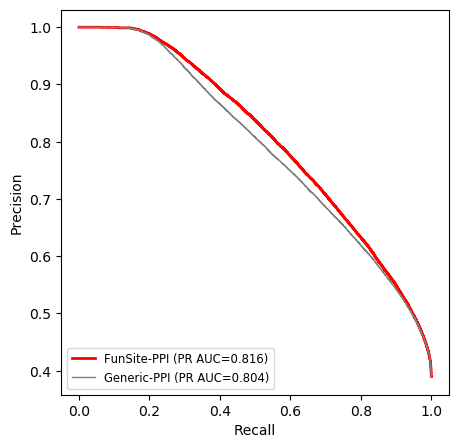

In [14]:
label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_generic)

plt.rcdefaults()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['axes.facecolor']='white'

plt.plot(recall_ff, precision_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_generic, precision_generic, label=label_generic, lw=1, color='grey')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize='small')
#plt.savefig('PPI-ibis_interchain_vs_generic.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
xmodel_ff = XGBClassifier(
            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
    
)

xmodel_gen = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)

xmodel_ff.fit(X_ff, y)
xmodel_gen.fit(X_generic, y)

# Saving models with joblib
modelname = 'PPI_Funsite_model_JW_version_with_GEOMETRICUS.sav'
joblib.dump(xmodel_ff, modelname)

/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:23:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  b

['PPI_Funsite_model_JW_version_with_GEOMETRICUS.sav']

In [33]:
# model that only uses the geometricus features and nothing else
X_geo = training_data_ML[features_geometricus_generic]
X_val_geo = validation_data_ML[features_geometricus_generic]

xmodel_geo = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)

xmodel_geo.fit(X_geo, y)
validation_geo_pred = xmodel_geo.predict_proba(X_val_geo)[:, 1]
precision_val_geo, recall_val_geo, thresholds_val_geo = precision_recall_curve(y_val,validation_geo_pred)
pr_auc_val_geo = auc(recall_val_geo, precision_val_geo)
label_geo = 'GeometricusOnly-PPI (PR AUC=%.3f)' % (pr_auc_val_geo)
print(label_geo)

/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GeometricusOnly-PPI (PR AUC=0.589)


In [38]:
# model that only uses the geometricus AND GENERIC
X_geogen = training_data_ML[features_geometricus_generic]
X_val_geogen = validation_data_ML[features_geometricus_generic]

xmodel_geogen = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)

xmodel_geogen.fit(X_geogen, y)
validation_geogen_pred = xmodel_geogen.predict_proba(X_val_geogen)[:, 1]
precision_val_geogen, recall_val_geogen, thresholds_val_geogen = precision_recall_curve(y_val,validation_geogen_pred)
pr_auc_val_geogen = auc(recall_val_geogen, precision_val_geogen)
label_geogen = 'GeometricusGeneric-PPI (PR AUC=%.3f)' % (pr_auc_val_geogen)
print(label_geogen)

/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:34:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GeometricusGeneric-PPI (PR AUC=0.719)


### FunSite-PPI compared to other predictors on the PPI holdout set

In [16]:
X_val_funsite = validation_data_ML[features_ff]
X_val_generic = validation_data_ML[features_generic]

y_val = validation_data_ML['annotation_IBIS_PPI_INTERCHAIN']

validation_funsite_pred = xmodel_ff.predict_proba(X_val_funsite)[:, 1]
validation_generic_pred = xmodel_gen.predict_proba(X_val_generic)[:, 1]

precision_val_ff, recall_val_ff, thresholds_val_ff = precision_recall_curve(y_val,validation_funsite_pred)
precision_val_generic, recall_val_generic, thresholds_val_generic = precision_recall_curve(y_val,validation_generic_pred)
pr_auc_val_ff = auc(recall_val_ff, precision_val_ff)
pr_auc_val_generic = auc(recall_val_generic, precision_val_generic)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

In [30]:
print(label_ff)
print(label_generic)

FunSite-PPI (PR AUC=0.817)
Generic-PPI (PR AUC=0.801)


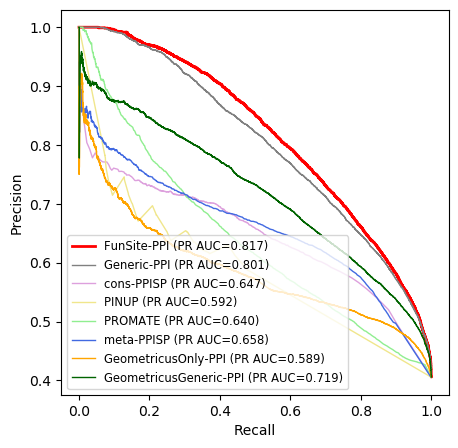

In [39]:
validation_cons_ppisp = validation_data_ML['cons_ppisp']
validation_pinup = validation_data_ML['pinup']
validation_promate = validation_data_ML['promate']
validation_meta_ppisp = validation_data_ML['meta_ppisp']
validation_meta_ppisp_predict = validation_data_ML['meta_predict']

precision_val_cons_ppisp, recall_val_cons_ppisp, thresholds_val_cons_ppisp = precision_recall_curve(y_val,validation_cons_ppisp)
precision_val_pinup, recall_val_pinup, thresholds_val_pinup = precision_recall_curve(y_val,validation_pinup)
precision_val_promate, recall_val_promate, thresholds_val_promate = precision_recall_curve(y_val,validation_promate)
precision_val_meta_ppisp, recall_val_meta_ppisp, thresholds_val_meta_ppisp = precision_recall_curve(y_val,validation_meta_ppisp)
precision_val_meta_ppisp_predict, recall_val_meta_ppisp_predict, thresholds_val_meta_ppisp_predict = precision_recall_curve(y_val,validation_meta_ppisp_predict)

pr_auc_val_cons_ppisp = auc(recall_val_cons_ppisp, precision_val_cons_ppisp)
pr_auc_val_pinup = auc(recall_val_pinup, precision_val_pinup)
pr_auc_val_promate = auc(recall_val_promate, precision_val_promate)
pr_auc_val_meta_ppisp = auc(recall_val_meta_ppisp, precision_val_meta_ppisp)
pr_auc_val_meta_ppisp_predict = auc(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict)

label_cons_ppisp = 'cons-PPISP (PR AUC=%.3f)' % (pr_auc_val_cons_ppisp)
label_pinup = 'PINUP (PR AUC=%.3f)' % (pr_auc_val_pinup)
label_promate = 'PROMATE (PR AUC=%.3f)' % (pr_auc_val_promate)
label_meta_ppisp = 'meta-PPISP (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp)
label_meta_ppisp_predict = 'meta-PPISP-predict (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp_predict)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

plt.plot(recall_val_ff, precision_val_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_val_generic, precision_val_generic, label=label_generic, lw=1, color='grey')

plt.plot(recall_val_cons_ppisp, precision_val_cons_ppisp, label=label_cons_ppisp, lw=1, color='plum')#
plt.plot(recall_val_pinup, precision_val_pinup,label=label_pinup,  lw=1, color='khaki')#
plt.plot(recall_val_promate, precision_val_promate, label=label_promate,  lw=1, color='lightgreen')#
plt.plot(recall_val_meta_ppisp, precision_val_meta_ppisp, label=label_meta_ppisp, lw=1, color='royalblue')
#plt.plot(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict, label=label_meta_ppisp_predict, lw=1, color='blue')


# ADD THE CURVE FOR THE GEOMETRICUS ONLY and GEOMETRICUS+GENERIC FEATURES
plt.plot(recall_val_geo, precision_val_geo, label=label_geo, lw=1, color='orange')#
plt.plot(recall_val_geogen, precision_val_geogen, label=label_geogen, lw=1, color='darkgreen')



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(fontsize='small', loc='lower left')
#plt.savefig('PPI-IBIS_INTERCHAIN_vs_others_TEST.png', dpi=300, bbox_inches='tight')
plt.show()

(array([2794., 2112., 2309., 2926., 3402., 3901., 4336., 4704., 5282.,
        8374.]),
 array([0.00358112, 0.10315418, 0.20272723, 0.3023003 , 0.40187335,
        0.5014464 , 0.60101944, 0.7005925 , 0.8001656 , 0.8997386 ,
        0.9993117 ], dtype=float32),
 <a list of 10 Patch objects>)

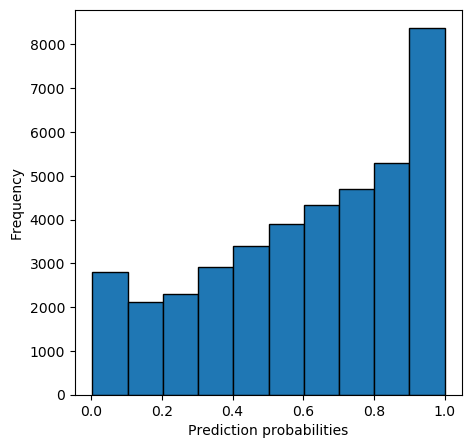

In [18]:
plt.xlabel('Prediction probabilities')
plt.ylabel('Frequency')

plt.hist(validation_funsite_pred, edgecolor='black', linewidth=1) 
#plt.savefig('PPI_validation_prediction_probabilities_hist.png', dpi=300, bbox_inches='tight')

In [19]:
import sklearn
from sklearn import metrics
sorted(sklearn.metrics.SCORERS.keys())
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score, make_scorer

mcc_scorer = make_scorer(matthews_corrcoef)

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))

diff_scores = ['roc_auc','accuracy', 'precision', 'recall', 'f1']

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))

print('ROC_AUC:')
print('ff=',xg_scores_ff['test_roc_auc'].mean(), 'generic=', xg_scores_gen['test_roc_auc'].mean())

print('\nPrecision:')
print('ff=',xg_scores_ff['test_precision'].mean(),  'generic=', xg_scores_gen['test_precision'].mean())

print('\nRecall')
print('ff=',xg_scores_ff['test_recall'].mean(),  'generic=', xg_scores_gen['test_recall'].mean())

print('\nF1:')
print('ff=',xg_scores_ff['test_f1'].mean(),  'generic=', xg_scores_gen['test_f1'].mean())

print('\nAccuracy:')
print('ff=',xg_scores_ff['test_accuracy'].mean(), 'generic=', xg_scores_gen['test_accuracy'].mean())

TypeError: cross_validate() takes from 2 to 3 positional arguments but 4 positional arguments (and 2 keyword-only arguments) were given

#### Generate FunSite-PPI model without 175 domains for combined predictor

In [ ]:
domains175_list = ['3mddA03', '1itqA00', '1xa8A00', '1os7A00', '1oroA00', '1ct9A02', '1odtC00', '1qprA02', '1d4aA00', '1fdyA00', '1cjuA00', '1n0hB03', '1j21A01', '2hwgA03', '1zp3A00', '1fuqA02', '1arzA02', '1soxA02', '1b8gA02', '1v54A00', '1ordA02', '1qinA00', '1rm0A01', '3csmA00', '2qutA00', '2c3mA01', '1kwsA00', '1ct9A01', '1kqfC00', '1idtA00', '1dqsA02', '1rk2A00', '1mumA00', '1mt5A00', '1l8sA00', '1d8dB00', '1nvmA02', '1wgiA00', '1rypI00', '2ahjA00', '1psdA02', '1j49A02', '1dqsA01', '1grcA00', '1ivhA02', '1qsgA00', '1cb7B01', '1cjuB00', '1jm6A01', '1a50B02', '1cb7A00', '1afrA00', '1nbaA00', '2ag0B01', '1oasA01', '1j79A00', '1e19A00', '1dqaA03', '1oe8A01', '2gsaA02', '2ocpA00', '1hyoA02', '1d8hA00', '2qf7A04', '1h7xA05', '1gpmA02', '1ksjA00', '1gz6A01', '1f61A00', '2esdA02', '1pvdB01', '1x7dA02', '1b7yA00', '1rvvA00', '3ey9A03', '1hxqA02', '1cqjA02', '1apxA02', '1dtwA00', '1bmfD02', '1tkkA02', '1hy3A00', '1fuiA02', '1ndoE01', '1ycfA01', '1dtwB02', '1ey3A01', '4mdhA02', '1xldA00', '1qhfA00', '2qf7A02', '1u8vA03', '1l6gB02', '1fc4A01', '1uqtA02', '1dqaA02', '1trkB02', '1djoA01', '1n62B05', '1cl1A01', '1j21A02', '1reqA01', '2gh5B03', '1dekA02', '1nwwA00', '1bouB00', '1hrkA02', '12asA00', '1snnA00', '1bzyA00', '1iphA01', '1cf2P02', '1cevA00', '1trkA01', '1dqrA02', '1ybvA00', '1dxeA00', '1ozhA04', '1mroA02', '1fr8A00', '1mpyA02', '1oacA03', '1a05A00', '1dqrA01', '1gxsA00', '2cjaA02', '2pz0A00', '1bxrA02', '1rgqA02', '1dhfA00', '1n0hA01', '1n2cA02', '1dtyA02', '1rblA02', '1iydA02', '1pvdA03', '3ecaB02', '1b57A00', '1niaA01', '1gt7A00', '1l6gA01', '1nfsA00', '1n2cB01', '1imaA01', '1fuiA03', '1f2dA01', '1diiA04', '1oasA02', '1gzgA00', '1htoA01', '1hzzA01', '1b3rA01', '1jrpB04', '1do6A00', '2hdhA01', '1diiC00', '1p4rA04', '1alkA00', '1qfeA00', '1ec9A02', '1uaqA00', '1dbtA00', '1hr6B01', '1g64A00', '1g99A02', '1bd3A00', '1a50A00', '2ahjB01', '1aq0A00', '1sesA02', '1rozA00', '1i58A00', '1ndpB00', '1d8dA00', '1x9hA01']

ppidf_no175 = raw_feature_data[~raw_feature_data['domain'].isin(domains175_list)]
ppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN== 1) ]
ppi_doms = ppi.domain.unique()

nonppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN == 0 ) & ppidf_no175.domain.isin(ppi_doms)] 
nonppi['index']=nonppi['residue_string']
ppi['index']=ppi['residue_string']

ppidf_no175_trainML = preprocess_site_nonsite_df(ppi, nonppi, 4)
ppidf_no175_trainML.sort_values(['domain']).head(2)

X_no175 = ppidf_no175_trainML[features_ff]
y_no175 = ppidf_no175_trainML['annotation_IBIS_PPI_INTERCHAIN']

ppi_model_no175 = XGBClassifier(

    n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)
ppi_model_no175.fit(X_no175, y_no175)

modelname = 'PPI_Funsite_xmodel_no175.sav'
joblib.dump(ppi_model_no175, modelname)

In [48]:
y.mean()
y_val.mean()
(training_data_ML[training_data_ML['annotation_IBIS_PPI_INTERCHAIN']==0].r1==-1).mean()

0.019782212307347533